In this notebook, we implement gradient descent from scratch. The idea is to calculate the different steps with pen and paper for comparison, at least the first iteration. This will help understand the algorithm steps in more depth.
Our task is to fit a line through 3 example data points. This regression problem can be thought of as a tiny neural net with just one neuron: an input $x_1$ weighted by $\theta_1$, a bias $\theta_0$ and a predicted output $\hat{y}$.

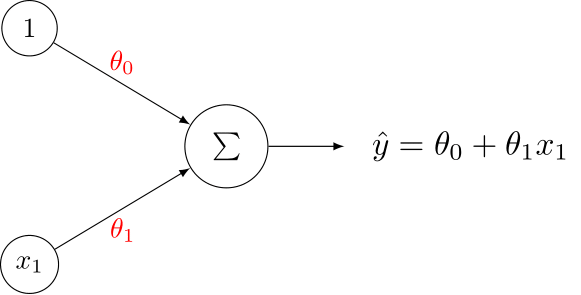

In [3]:
from IPython.display import Image
Image('neuron.png', width=400)

In [5]:
# imports
import numpy as np
import matplotlib.pyplot as plt

As fictional application, we want to predict median house prices in an area based on median income in this region. We have 3 data points as training data:

In [16]:
# 3 data points to be fitted by a regression line (stored as 2D array for matrix calculations)
x = np.array([[100], [70], [140]]) # income (in 1000)
y = np.array([[300], [200], [500]]) # house price (in 1000)

# we add a constant value 1 for the bias term (to be multiplied with theta0)
x_with_bias = np.concatenate((np.ones((len(x), 1)), x), axis=1)
print('x_with_bias = ', x_with_bias)
print('y = ', y)

x_with_bias =  [[  1. 100.]
 [  1.  70.]
 [  1. 140.]]
y =  [[300]
 [200]
 [500]]


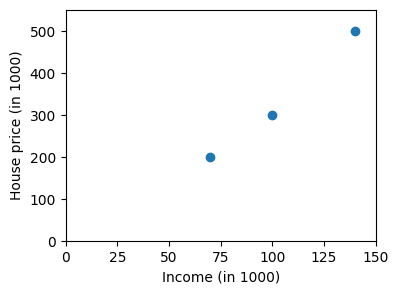

In [21]:
# plot data
def plot_points():
    plt.figure(figsize=(4, 3))
    plt.scatter(x, y)
    plt.axis([0, 150, 0, 550])
    plt.xlabel('Income (in 1000)')
    plt.ylabel('House price (in 1000)')

plot_points()